# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and XGBoost, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and XGBoost.

N-Beats is a deep learning model designed specifically for time-series forecasting, while XGBoost is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [1]:
import darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import os
import sys
import sklearn 
import torch
from utils import DataFrameProcessor, ModelPipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts import TimeSeries
import darts.metrics as metrics
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Data Extraction

In [2]:
processor = DataFrameProcessor('exabel_data')

In [3]:
# / TODO add covid data as it may be a strong covariate for the time series at question
processor.files

['revenue.xlsx', '.DS_Store', 'covid_us.csv', 'spend_amounts_aggregated.xlsx']

In [4]:
revenue = processor.create_df(processor.revenue)
spendings = processor.create_df(processor.spendings)
df = processor.merge_spendings_revenue(spendings, revenue)
df = processor.create_stationary_covariates(df)
df = processor.add_war_to_df(df)
df = processor.encode_index(df)

## Data Exploration

In [5]:
df.tail(3)

,mic,ticker,time,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
4006,3.0,LULU,2022-05-01,222188.49,65185.76,1613.463,1546.1787,2022,5,2,1
4007,3.0,LULU,2022-07-31,247761.91,82829.00,1868.328,1773.8601,2022,7,3,1
4008,3.0,LULU,2022-10-30,266265.89,94487.46,1856.889,1814.2972,2022,10,4,1


In [6]:
# showing the unique number of companies
# each company correspond to a unique time series used during training
len(df['ticker'].unique())

267

Text(0.5, 1.0, 'SEAT')

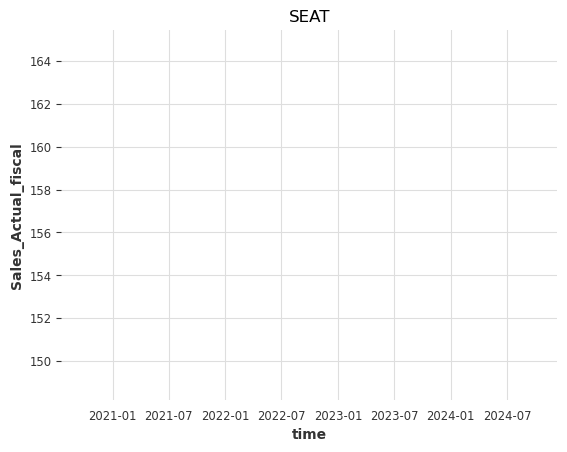

In [7]:
# TICKERS TO SELECT FROM:

# 'FLWS', 'AMC', 'T', 'ANF', 'ASO', 'ATVI', 'ADBE', 'AAP', 'AFRM',
# 'ABNB', 'ALK', 'ACI', 'ALGT', 'ALLY', 'GOOGL', 'ATUS', 'AMZN',
# 'AMXL', 'AAL', 'AEO', 'AEP', 'ANGI', 'AAPL', 'ARMK', 'AZO', 'CAR',
# 'BARK', 'BJRI', 'BJ', 'BP', 'BBWI', 'BBBY', 'BBY', 'BIG', 'SQ',
# 'BLMN', 'APRN', 'BKNG', 'BOOT', 'EAT', 'BBW', 'BMBL', 'BURL',
# 'CVS', 'CAL', 'CWH', 'CTLP', 'CPRI', 'KMX', 'CCL', 'CRI', 'CASY',
# 'FUN', 'CHTR', 'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH',
# 'CMPR', 'CNK', 'CTRN', 'COIN', 'CMCSA', 'CONN', 'COP', 'COST',
# 'CBRL', 'CROX', 'CUBE', 'DISH', 'DRI', 'PLAY', 'DECK', 'DAL',
# 'DENN', 'DBI', 'DXLG', 'DKS', 'DDS', 'DIN', 'DG', 'DLTR', 'DPZ',
# 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA', 'EFX', 'EL', 'ETSY', 'EB',
# 'ES', 'EXPE', 'EXPN', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FLTR',
# 'FL', 'FTV', 'FRG', 'FTDR', 'ULCC', 'GME', 'GPS', 'GEN', 'GM',
# 'GCO', 'GPC', 'GDDY', 'GO', 'GRPN', 'HRB', 'HOG', 'HLF', 'HTZ',
# 'HIBB', 'HLT', 'HUM', 'H', 'IAC', 'INTU', 'JACK', 'JBLU', 'KSS',
# 'AD', 'DNUT', 'LL', 'MC', 'LE', 'LEVI', 'LYV', 'LOW', 'LYFT', 'M',
# 'MPC', 'MAR', 'MTCH', 'MAT', 'MCD', 'META', 'MSFT', 'MGI', 'MUSA',
# 'NKE', 'NAVI', 'NFLX', 'NWL', 'NDLS', 'JWN', 'NCLH', 'ORLY',
# 'OLLI', 'OMF', 'OSTK', 'OXM', 'PENN', 'PVH', 'PZZA', 'PRTYQ',
# 'PYPL', 'PTON', 'PETS', 'PSX', 'PLNT', 'PLTK', 'POSH', 'PBPB',
# 'PGR', 'DGX', 'QRTEA', 'RL', 'RRGB', 'RCII', 'RSG', 'QSR', 'RAD',
# 'RBLX', 'ROKU', 'ROL', 'ROST', 'RSI', 'SBH', 'SCHL', 'SEAS', 'S',
# 'SHAK', 'SHEL', 'SCVL', 'SHOP', 'SIG', 'SIRI', 'SIX', 'SKX',
# 'SKLZ', 'SNA', '6758', 'LUV', 'LOV', 'SAVE', 'SPOT', 'SFM', 'SBUX',
# 'SFIX', 'SUN', 'TMUS', 'TPR', 'TGT', 'TXRH', 'AAN', 'ALL', 'BKE',
# 'CATO', 'PLCE', 'TCS', 'HIG', 'HD', 'KR', 'NYT', 'ODP', 'SHW',
# 'TJX', 'TRV', 'DIS', 'WEN', 'TSCO', 'TA', 'TUP', 'UHAL', 'UBER',
# 'ULTA', 'UAA', 'UAL', 'UPS', 'USM', 'UNH', 'URBN', 'VFC', 'VVV',
# 'VRA', 'VZ', 'SEAT', 'VVNT', 'WW', 'WBA', 'WMT', 'WM', 'W', 'WSM',
# 'WING', 'WINA', 'WIX', 'WH', 'YETI', 'YUM', 'ZM', 'ZUMZ', 'EBAY',
# 'FUBO', 'IMBI', 'LULU'

test_company = 'SEAT'

df_test = df[df['ticker'] == test_company]
sns.lineplot(x=df_test['time'], y=df_test['Sales_Actual_fiscal'])
plt.title(test_company)

In [8]:
for tic in df.ticker:
    if len(df[df['ticker'] == tic]) < 7:
        # print(len(df[df['ticker'] == tic]))
        pass

In [9]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    193
nw_total_sales_b_total    806
Sales_Actual_fiscal       142
Sales_Estimate_fiscal     180
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

In [10]:
# Correlation Matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_36957/1287959622.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
mic,1.000000,-0.008888,0.037614,-0.024525,-0.027886,0.007763,0.000345,0.005458,0.009216
nw_total_sales_a_total,-0.008888,1.000000,0.949227,0.205405,0.207228,0.037013,-0.014673,-0.007128,0.035410
nw_total_sales_b_total,0.037614,0.949227,1.000000,0.205773,0.207251,0.029660,-0.007203,-0.001299,0.022611
Sales_Actual_fiscal,-0.024525,0.205405,0.205773,1.000000,0.999677,0.025585,0.015691,0.007223,0.040426
Sales_Estimate_fiscal,-0.027886,0.207228,0.207251,0.999677,1.000000,0.023955,0.015080,0.006591,0.038954
year,0.007763,0.037013,0.029660,0.025585,0.023955,1.000000,-0.260605,-0.222666,0.667710
month,0.000345,-0.014673,-0.007203,0.015691,0.015080,-0.260605,1.000000,0.972838,-0.084105
quarter,0.005458,-0.007128,-0.001299,0.007223,0.006591,-0.222666,0.972838,1.000000,-0.066946
is_war,0.009216,0.035410,0.022611,0.040426,0.038954,0.667710,-0.084105,-0.066946,1.000000


Based on the strong linear correlation between total sales between group A and B, it can make sense to find a linear model for when these are NaN based on the values for which they are not NaN and make mappings between them and impute values from those linear mappings. Can also include Sales_Actual / Sales_Estimate in the linear model

In [11]:
df.dropna(subset=['Sales_Actual_fiscal'], inplace=True)
df.isna().sum()

mic                        16
ticker                      0
time                        0
nw_total_sales_a_total    178
nw_total_sales_b_total    765
Sales_Actual_fiscal         0
Sales_Estimate_fiscal      40
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

In [12]:
df.shape

(3867, 11)

# Building Series from Darts

In [13]:
model = ModelPipeline(df)

In [14]:
series_dict = model.get_covs_target_dict()

In [15]:
df[df['ticker'] == 'LULU']

,mic,ticker,time,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
3991,3.0,LULU,2018-07-29,57414.19,NaN,723.500,667.96400,2018,7,3,0
3992,3.0,LULU,2018-10-28,63852.52,NaN,747.655,737.52370,2018,10,4,0
3993,3.0,LULU,2019-02-03,106998.02,NaN,1167.450,1151.72440,2019,2,1,0
3994,3.0,LULU,2019-05-05,60821.39,30807.16,782.315,756.11020,2019,5,2,0
3995,3.0,LULU,2019-08-04,76463.52,31334.07,883.352,845.58980,2019,8,3,0
3996,3.0,LULU,2019-11-03,83532.26,37889.27,916.138,899.27386,2019,11,4,0
3997,3.0,LULU,2020-02-02,170870.52,70525.88,1397.491,1382.60900,2020,2,1,0
3998,3.0,LULU,2020-05-03,91155.77,38798.29,651.962,691.62920,2020,5,2,0
3999,3.0,LULU,2020-08-02,139472.10,60155.86,902.942,844.47534,2020,8,3,0
4000,3.0,LULU,2020-11-01,178020.45,83626.30,1117.426,1015.96277,2020,11,4,0


In [16]:
series_dict['LULU'][0]

<TimeSeries (DataArray) (time: 18, component: 7, sample: 1)>
array([[[5.74141900e+04],
        [           nan],
        [6.67964000e+02],
        [2.01800000e+03],
        [7.00000000e+00],
        [3.00000000e+00],
        [0.00000000e+00]],

       [[6.38525200e+04],
        [           nan],
        [7.37523700e+02],
        [2.01800000e+03],
        [1.00000000e+01],
        [4.00000000e+00],
        [0.00000000e+00]],

       [[1.06998020e+05],
        [           nan],
        [1.15172440e+03],
        [2.01900000e+03],
...
        [2.02200000e+03],
        [5.00000000e+00],
        [2.00000000e+00],
        [1.00000000e+00]],

       [[2.47761910e+05],
        [8.28290000e+04],
        [1.77386010e+03],
        [2.02200000e+03],
        [7.00000000e+00],
        [3.00000000e+00],
        [1.00000000e+00]],

       [[2.66265890e+05],
        [9.44874600e+04],
        [1.81429720e+03],
        [2.02200000e+03],
        [1.00000000e+01],
        [4.00000000e+00],
        [1.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-09-30 2018-12-31 ... 2022-12-31
  * component  (component) object 'nw_total_sales_a_total' ... 'is_war'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  2018-09-30  2018-12-31  2019-03-31...
    hierarchy:          None